In [1]:
%matplotlib inline

# feature_importance_permutation: Estimate feature importance via feature permutation.

A function to estimate the feature importance of classifiers and regressors based on *permutation importance*.

> `from mlxtend.evaluate import feature_importance_permutation`    

## Overview

The *permutation importance* is an intuitive, model-agnostic method to estimate the feature importance for classifier and regression models. The approach is relatively simple and straight-forward:

1. Take a model that was fit to the training dataset
2. Estimate the predictive performance of the model on an independent dataset (e.g., validation dataset) and record it as the baseline performance
3. For each feature *i*:
   - randomly permute feature column *i* in the original dataset
   - record the predictive performance of the model on the dataset with the permuted column 
   - compute the feature importance as the difference between the baseline performance (step 2) and the performance on the permuted dataset

Permutation importance is generally considered as a relatively efficient technique that works well in practice [1], while a drawback is that the importance of correlated features may be overestimated [2].


### References

- [1] Terence Parr, Kerem Turgutlu, Christopher Csiszar, and Jeremy Howard. *Beware Default Random Forest Importances* (http://parrt.cs.usfca.edu/doc/rf-importance/index.html)
- [2] Strobl, C., Boulesteix, A. L., Kneib, T., Augustin, T., & Zeileis, A. (2008). Conditional variable importance for random forests. BMC bioinformatics, 9(1), 307.

## Example 1 -- Feature Importance for Classifiers

The following example illustrates the feature importance estimation via permutation importance based for classification models.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import feature_importance_permutation

#### Generate a toy dataset

In [3]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=10000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

#### Feature importance via random forest

First, we compute the feature importance directly from the random forest via *mean impurity decrease* (described after the code section):

In [4]:
forest = RandomForestClassifier(n_estimators=250,
                                random_state=0)

forest.fit(X_train, y_train)

print('Training accuracy:', np.mean(forest.predict(X_train) == y_train)*100)
print('Test accuracy:', np.mean(forest.predict(X_test) == y_test)*100)

importance_vals = forest.feature_importances_
print(importance_vals)

Training accuracy: 100.0
Test accuracy: 95.06666666666666
[0.283357   0.30846795 0.24204291 0.02229767 0.02364941 0.02390578
 0.02501543 0.0234225  0.02370816 0.0241332 ]


There are several strategies for computing the feature importance in random forest. The method implemented in scikit-learn (used in the next code example) is based on the Breiman and Friedman's CART (Breiman, Friedman, "Classification and regression trees", 1984), the so-called *mean impurity decrease*. Here, the importance value of a features is computed by averaging the impurity decrease for that feature, when splitting a parent node into two child nodes, across all the trees in the ensemble. Note that the impurity decrease values are weighted by the number of samples that are in the respective nodes. This process is repeated for all features in the dataset, and the feature importance values are then normalized so that they sum up to 1. In CART, the authors also note that this fast way of computing feature importance values is relatively consistent with the permutation importance.

Next, let's visualize the feature importance values from the random forest including a measure of the *mean impurity decrease* variability (here: standard deviation):

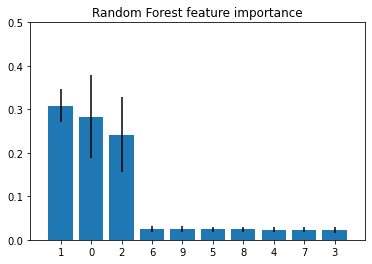

In [5]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importance_vals)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Random Forest feature importance")
plt.bar(range(X.shape[1]), importance_vals[indices],
        yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.5])
plt.show()

As we can see, the features 1, 0, and 2 are estimated to be the most informative ones for the random forest classier. Next, let's compute the feature importance via the permutation importance approach.

#### Permutation Importance

In [6]:
imp_vals, _ = feature_importance_permutation(
    predict_method=forest.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=1,
    seed=1)

imp_vals

array([ 0.26833333,  0.26733333,  0.261     , -0.002     , -0.00033333,
        0.00066667,  0.00233333,  0.00066667,  0.00066667, -0.00233333])

Note that the `feature_importance_permutation` returns two arrays. The first array (here: `imp_vals`) contains the actual importance values we are interested in. If `num_rounds > 1`, the permutation is repeated multiple times (with different random seeds), and in this case the first array contains the average value of the importance computed from the different runs. The second array (here, assigned to `_`, because we are not using it) then contains all individual values from these runs (more about that later).

Now, let's also visualize the importance values in a barplot:

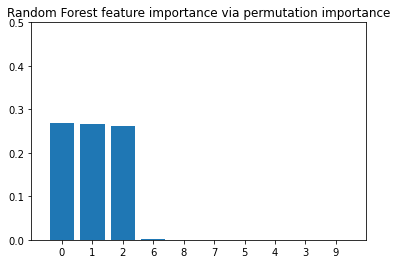

In [7]:
indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.title("Random Forest feature importance via permutation importance")
plt.bar(range(X.shape[1]), imp_vals[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.5])
plt.show()

As we can see, also here, features 1, 0, and 2 are predicted to be the most important ones, which is consistent with the feature importance values that we computed via the *mean impurity decrease* method earlier.

(Note that in the context of random forests, the feature importance via permutation importance is typically computed using the out-of-bag samples of a random forest, whereas in this implementation, an independent dataset is used.)

Previously, it was mentioned that the permutation is repeated multiple times if `num_rounds > 1`. In this case, the second array returned by the `feature_importance_permutation` contains the importance values for these individual runs (the array has shape [num_features, num_rounds), which we can use to compute some sort of variability between these runs. 

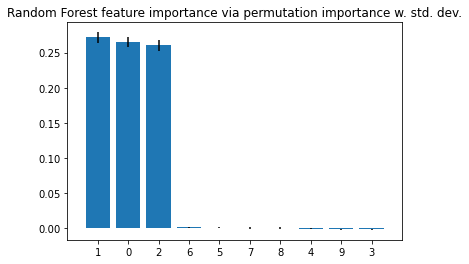

In [ ]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=forest.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=10,
    seed=1)


std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("Random Forest feature importance via permutation importance w. std. dev.")
plt.bar(range(X.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

It shall be noted that the feature importance values do not sum up to one, since they are not normalized (you can normalize them if you'd like, by dividing these by the sum of importance values). Here, the main point is to look at the importance values relative to each other and not to over-interpret the absolute values.

#### Support Vector Machines

While the permutation importance approach yields results that are generally consistent with the *mean impurity decrease* feature importance values from a random forest, it's a method that is model-agnostic and can be used with any kind of classifier or regressor. The example below applies the `feature_importance_permutation` function to a support vector machine:

In [ ]:
from sklearn.svm import SVC


svm = SVC(C=1.0, kernel='rbf')
svm.fit(X_train, y_train)

print('Training accuracy', np.mean(svm.predict(X_train) == y_train)*100)
print('Test accuracy', np.mean(svm.predict(X_test) == y_test)*100)

Training accuracy 94.87142857142857
Test accuracy 94.89999999999999


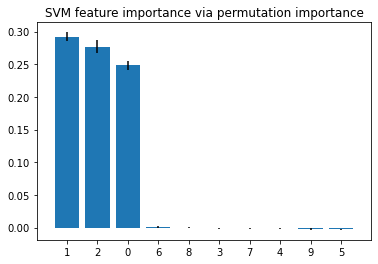

In [ ]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=svm.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=10,
    seed=1)


std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("SVM feature importance via permutation importance")
plt.bar(range(X.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Example 2 -- Feature Importance for Regressors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.evaluate import feature_importance_permutation
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.svm import SVR


X, y = make_regression(n_samples=1000,
                       n_features=5,
                       n_informative=2,
                       n_targets=1,
                       random_state=123,
                       shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)    

svm = SVR(kernel='rbf')
svm.fit(X_train, y_train)

imp_vals, _ = feature_importance_permutation(
    predict_method=svm.predict, 
    X=X_test,
    y=y_test,
    metric='r2',
    num_rounds=1,
    seed=1)

imp_vals

array([ 0.43309137,  0.22058866,  0.00148447,  0.01613953, -0.00529505])

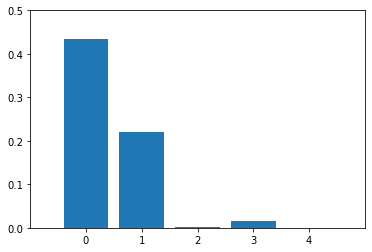

In [ ]:
plt.figure()
plt.bar(range(X.shape[1]), imp_vals)
plt.xticks(range(X.shape[1]))
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.5])
plt.show()

## Example 3 -- Feature Importance With One-Hot-Encoded Features

Upon one-hot encoding, a feature variable with 10 distinct categories will be split into 10 new feature columns (or 9, if you drop a redundant column). If we want to treat each new feature column as an individual feature variable, we can use the `feature_importance_permutation` as usual. 

This is illustrated in the example below.

### Preparing the Dataset

Here, we look at a dataset that consists of one categorical feature (`'categorical'`) and 3 numerical features (`'measurement1'`, `'measurement2'`, and `'measurement3'`).

In [ ]:
import pandas as pd


df_data = pd.read_csv('https://gist.githubusercontent.com/rasbt/b99bf69079bc0d601eeae8a49248d358/raw/a114be9801647ec5460089f3a9576713dabf5f1f/onehot-numeric-mixed-data.csv')
df_data.head()

,categorical,measurement1,measurement2,label,measurement3
0,F,1.428571,2.721313,0,2.089
1,R,0.685939,0.982976,0,0.637
2,P,1.055817,0.624210,0,0.226
3,S,0.995956,0.321101,0,0.138
4,R,1.376773,1.578309,0,0.478


In [ ]:
from sklearn.model_selection import train_test_split


df_X = df_data[['measurement1', 'measurement2', 'measurement3', 'categorical']]
df_y = df_data['label']


df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
     df_X, df_y, test_size=0.33, random_state=42, stratify=df_y)

Here, we do the one-hot encoding on the categorical feature and merge it back with the numerical columns:

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np


ohe = OneHotEncoder(drop='first')
ohe.fit(df_X_train[['categorical']])

df_X_train_ohe = df_X_train.drop(columns=['categorical'])
df_X_test_ohe = df_X_test.drop(columns=['categorical'])

ohe_train = np.asarray(ohe.transform(df_X_train[['categorical']]).todense())
ohe_test = np.asarray(ohe.transform(df_X_test[['categorical']]).todense())

X_train_ohe = np.hstack((df_X_train_ohe.values, ohe_train))
X_test_ohe = np.hstack((df_X_test_ohe.values, ohe_test))

In [ ]:
# look at first 3 rows
print(X_train_ohe[:3])

[[0.65747208 0.95105388 0.36       0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [1.17503636 1.01094494 0.653      0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [1.25516647 0.67575824 0.176      0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.        ]]


### Fitting a Baseline Model for Analysis

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


pipe = make_pipeline(StandardScaler(),
                     MLPClassifier(max_iter=10000, random_state=123))

params = {
    'mlpclassifier__hidden_layer_sizes': [(30, 20, 10), 
                                          (20, 10), 
                                          (20,),
                                          (10,)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd'],
    'mlpclassifier__alpha': [0.0001],
    'mlpclassifier__learning_rate': ['adaptive'],
}

gs = GridSearchCV(estimator=pipe, 
                  param_grid=params, 
                  scoring='accuracy', 
                  refit=True,
                  n_jobs=-1,
                  cv=10)

gs = gs.fit(X_train_ohe, df_y_train.values)
model = gs.best_estimator_

### Regular Permutation Importance

Here, we compute the feature importance the regular way were each one-hot encoded feature is treated as an individiual variable.

In [ ]:
from mlxtend.evaluate import feature_importance_permutation

In [ ]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model.predict, 
    X=X_test_ohe,
    y=df_y_test.values,
    metric='accuracy',
    num_rounds=50,
    seed=1)

In [ ]:
feat_names_with_ohe = ['measurement1', 'measurement2', 'measurement3'] \
    + [f'categorical_ohe_{i}' for i in range(2, 20)]

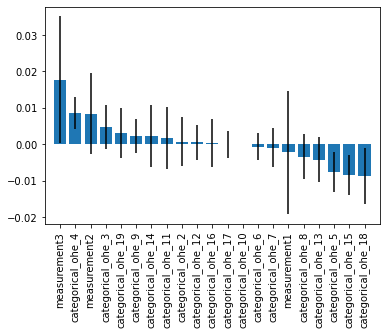

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt


std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
#plt.title("Feature importance via permutation importance w. std. dev.")
plt.bar(range(len(feat_names_with_ohe)), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(len(feat_names_with_ohe)),
           np.array(feat_names_with_ohe)[indices], rotation=90)
plt.xlim([-1, len(feat_names_with_ohe)])
plt.show()

However, notice that if we have a lot of categorical values, the feature importance of the individual binary features (after one hot encoding) are now hard to interpret. In certain cases, it would be desireable to treat the one-hot encoded binary features as a single variable in feature permutation importance evaluation. We can achieve this using feature groups.

### With Feature Groups

In the example below, all the one-hot encoded variables are treated as a feature group. This means, they are are all shuffled and analyzed as a single feature inside the feature permutation importance analysis.

In [23]:
feature_groups = [0, 1, 2, range(3, 21)]

imp_vals, imp_all = feature_importance_permutation(
    predict_method=model.predict, 
    X=X_test_ohe,
    y=df_y_test.values,
    metric='accuracy',
    num_rounds=50,
    feature_groups=feature_groups,
    seed=1)

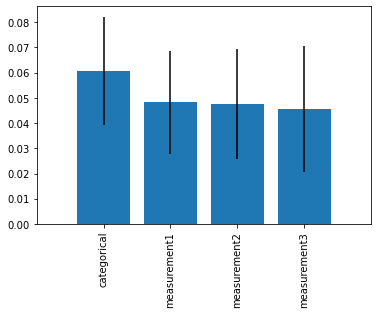

In [24]:
feature_names = ['measurement1', 'measurement2', 'measurement3', 'categorical']

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.bar(range(len(feature_names)), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(len(feature_names)),
           np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.show()

## API

In [25]:
with open('../../api_modules/mlxtend.evaluate/feature_importance_permutation.md', 'r') as f:
    s = f.read() 
print(s)

## feature_importance_permutation

*feature_importance_permutation(X, y, predict_method, metric, num_rounds=1, feature_groups=None, seed=None)*

Feature importance imputation via permutation importance

**Parameters**


- `X` : NumPy array, shape = [n_samples, n_features]

    Dataset, where n_samples is the number of samples and
    n_features is the number of features.


- `y` : NumPy array, shape = [n_samples]

    Target values.


- `predict_method` : prediction function

    A callable function that predicts the target values
    from X.


- `metric` : str, callable

    The metric for evaluating the feature importance through
    permutation. By default, the strings 'accuracy' is
    recommended for classifiers and the string 'r2' is
    recommended for regressors. Optionally, a custom
    scoring function (e.g., `metric=scoring_func`) that
    accepts two arguments, y_true and y_pred, which have
    similar shape to the `y` array.


- `num_rounds` : int (default=1)

    Number o